# Feature Engineering:
There might be more features from auction-level aggregation and user-level aggregation.

## Load data again

In [1]:
import pandas as pd
df = pd.read_csv('../data/Shill Bidding Dataset.csv', sep=',')

In [7]:
import mlflow
from mlflow import MlflowClient
from mlflow.exceptions import MlflowException

In [38]:
# MLflow experiment parameters for this project
EXPERIMENT_NAME = "shill-bidding-prediction"
mlflow.set_tracking_uri("../mlruns")
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='/Users/stefbp/Documents/GitHub/shill-bidding-prediction/exploration/../mlruns/982963971287762780', creation_time=1753349247035, experiment_id='982963971287762780', last_update_time=1753349247035, lifecycle_stage='active', name='shill-bidding-prediction', tags={}>

## Bidder-level feature engineering test.

In [26]:
from sklearn.model_selection import train_test_split

unique_auctions = df['Auction_ID'].unique() # auction-level split to avoid data leakage
train_auctions, test_auctions = train_test_split(unique_auctions, test_size=0.2, random_state=42)

df_train = df[df['Auction_ID'].isin(train_auctions)].copy()
df_test = df[df['Auction_ID'].isin(test_auctions)].copy()

In [27]:
# 1. All numeric columns to aggregate per bidder
bidder_features = [
    'Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding',
    'Last_Bidding', 'Early_Bidding', 'Winning_Ratio', 'Starting_Price_Average'
]

# 2. Compute bidder aggregates from train
bidder_agg = df_train.groupby('Bidder_ID')[bidder_features].agg(['mean', 'std', 'min', 'max', 'count'])
bidder_agg.columns = ['_'.join(col) for col in bidder_agg.columns]
bidder_agg = bidder_agg.reset_index()

# 3. Replace std NaNs (from bidders with only 1 row) with 0
std_cols = [col for col in bidder_agg.columns if col.endswith('_std')]
for col in std_cols:
    bidder_agg[col] = bidder_agg[col].fillna(0)

# 4. Join to train and test
df_train = df_train.merge(bidder_agg, on='Bidder_ID', how='left')
df_test = df_test.merge(bidder_agg, on='Bidder_ID', how='left')

# 5. Fill any NaNs in df_test (due to unseen Bidder_IDs) with train medians
for col in bidder_agg.columns:
    if col != 'Bidder_ID':
        median_val = df_train[col].median()
        df_test[col] = df_test[col].fillna(median_val)


In [ ]:
from sklearn.preprocessing import StandardScaler

feature_cols = [col for col in df_train.columns if col.endswith('_z') or any(stat in col for stat in ['_mean', '_std', '_count'])]

X_train = df_train[feature_cols]
X_test = df_test[feature_cols]
y_train = df_train['Class']
y_test = df_test['Class']

# Scale (optional for logistic regression, but good habit)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train the model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

/Users/stefbp/Documents/GitHub/shill-bidding-prediction/mlops-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/stefbp/Documents/GitHub/shill-bidding-prediction/mlops-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9094    0.1933    0.3188      1195
           1     0.1007    0.8244    0.1796       131

    accuracy                         0.2557      1326
   macro avg     0.5051    0.5089    0.2492      1326
weighted avg     0.8296    0.2557    0.3051      1326

Accuracy: 0.2557
Precision: 0.1007
Recall: 0.8244
F1 Score: 0.1796
AUC-ROC: 0.5064


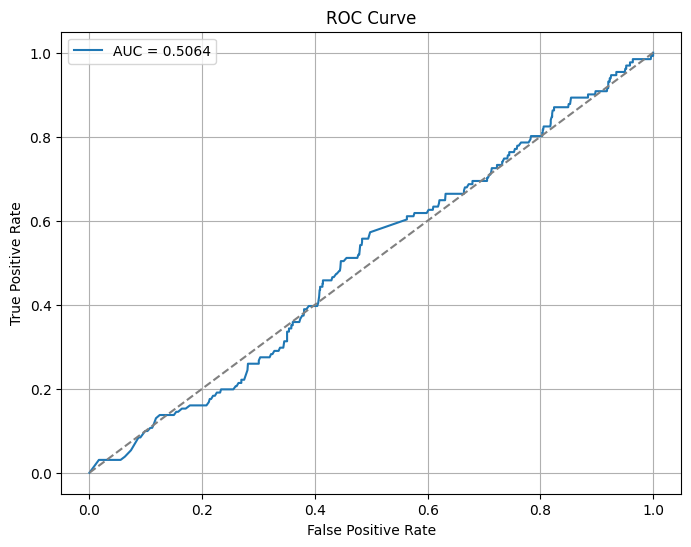

In [30]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report
)
import matplotlib.pyplot as plt

# Predict labels and probabilities
y_true = df_test['Class']
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Prob for class 1

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_proba)

print("=== Classification Report ===")
print(classification_report(y_true, y_pred, digits=4))
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

# Plot AUC-ROC curve
fpr, tpr, _ = roc_curve(y_true, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

All around bad.

In [34]:
## Auction-level feature engineering, with baseline.

import pandas as pd

# List of features to standardize within each auction
auction_feats = [
    'Bidder_Tendency', 'Bidding_Ratio', 'Successive_Outbidding',
    'Last_Bidding', 'Auction_Bids', 'Starting_Price_Average',
    'Early_Bidding', 'Winning_Ratio'
]

# Compute per-auction mean & std
auction_agg = df.groupby('Auction_ID')[auction_feats].agg(['mean', 'std'])
auction_agg.columns = ['_'.join(col) for col in auction_agg.columns]
auction_agg = auction_agg.reset_index()
auction_agg = auction_agg.fillna(1)

# Merge back to main df
df_aug = df.merge(auction_agg, on='Auction_ID', how='left')

# Standardize per auction: (value - auction mean) / auction std
for feat in auction_feats:
    mean_col = f"{feat}_mean"
    std_col = f"{feat}_std"
    z_col = f"{feat}_z"
    
    # Avoid division by zero
    df_aug[std_col] = df_aug[std_col].replace(0, 1)
    df_aug[z_col] = (df_aug[feat] - df_aug[mean_col]) / df_aug[std_col]

# Drop raw means/stds if you only want z-scores
drop_cols = [f"{f}_mean" for f in auction_feats] + [f"{f}_std" for f in auction_feats]
df_auction_aug = df_aug.drop(columns=drop_cols)


In [35]:
from sklearn.model_selection import train_test_split

# Split on Auction_ID to prevent auction leakage
unique_auctions = df_auction_aug['Auction_ID'].unique()
train_ids, test_ids = train_test_split(unique_auctions, test_size=0.3, random_state=42)

df_train = df_auction_aug[df_auction_aug['Auction_ID'].isin(train_ids)].copy()
df_test = df_auction_aug[df_auction_aug['Auction_ID'].isin(test_ids)].copy()

In [36]:
from sklearn.linear_model import LogisticRegression

feature_cols = [col for col in df_train.columns if col.endswith('_z')]
X_train = df_train[feature_cols]
y_train = df_train['Class']
X_test = df_test[feature_cols]
y_test = df_test['Class']

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9854    0.9843    0.9849      1784
           1     0.8634    0.8719    0.8676       203

    accuracy                         0.9728      1987
   macro avg     0.9244    0.9281    0.9263      1987
weighted avg     0.9729    0.9728    0.9729      1987

AUC-ROC: 0.9892


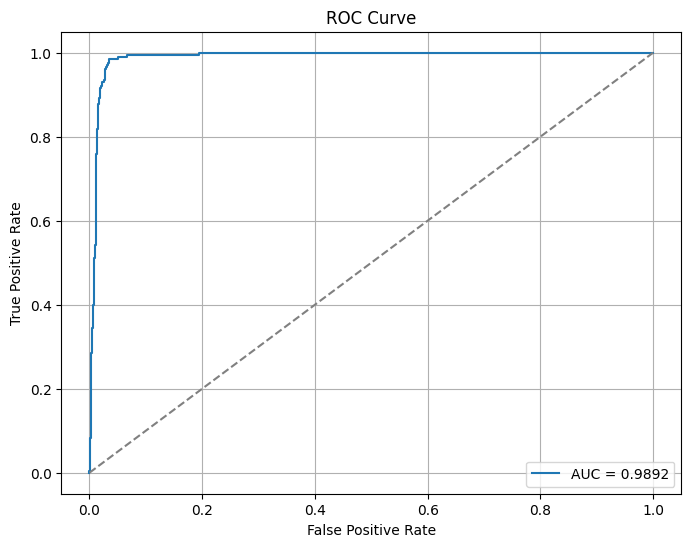

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AUC = {:.4f}'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.legend()
plt.show()